# Lab 2: Photodiode based light sensors

## Objective
In this lab we will explore photodiodes as a light sensors. This builds on the assignment you did modelling photodiode response. You will measure the response of the photodiode and also build an amplifier to improve performance.

## Setup
For this lab you need: Both mounted protoboards

- Both mounted protoboards
- Jumper wires
- The trinket
- The photodiode
- The book of resistors
- 1 MCP6241 Op-Amp (datasheet supplied)
- 2 0.1uF ceramic capacitors (small yellow ones)
- 1 10uF electrolytic capacitor (large red ones)

As with lab 1, put the Trinket on one board and build the circuit on the other with the photodiode aligned with the Trinket LED.



These are the libraries we will need for this lab

In [16]:
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants as const
import labtrinket
import serial
import time

Connect the trinket

In [25]:
ser = serial.Serial()
ser.port = 'COM5'
ser.baudrate = 9600
ser.open()
trinket = labtrinket.LabTrinket(ser)

We will use the average voltage function again from Lab1

In [26]:
def averageVoltage(n):
    trinket.adcRun()
    v = 0
    i = 0
    while i<n:
        if trinket.adcGetValue():
            val = trinket.value
            v = v + val
           # print("{:}->{:}".format(i,val))
            i = i+1
    trinket.adcStop()
    return v / n

Make a an array of brightnesses and another for output voltages

In [84]:
brightness = np.linspace(0,100,50)
voltage0 = np.zeros(50)
voltage22k = np.zeros(50)
voltage10k = np.zeros(50)
voltage2200 = np.zeros(50)
voltage220 = np.zeros(50)
voltageReverseBias = np.zeros(50)
voltageOpAmp = np.zeros(50)

## Task 1: Open circuit voltage

Set up as shown with the ADC connected to the positive anode and the cathode connected to ground (the anode is the _longer_ leg of the photodiode). Just as you did with the photoresistor experiment, set the trinket LED color to white, delay to 0.2 and turn on voltage mode. Arrange the photodiode so that it is pointing directly at the trinket LED and fairly close. 
Write a for loop to step through the brightness of the diode and store the measured voltages in the `voltageOC` array you created just before.

![OC Voltage Circuit](Photodiode.png "Open circuit measurement")

In [34]:
trinket.ledOn()
trinket.ledSetColor(255,255,255)
trinket.adcDelay(0.2)
trinket.adcVoltMode(True)

In [31]:
trinket.ledOn()
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    voltage0[i] = averageVoltage(5)
trinket.ledOff()

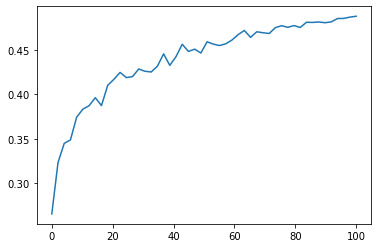

In [32]:
plt.plot(brightness,voltage0)

# Task2: External load resistor

We will continue to work in _photovoltaic mode_ by adding an external load resitor. Place the load resistor in parallel with the photodiode and measure with the ADC from the same two points. Obtain a series of measurements for a 22k$\Omega$, 10k$\Omega$, 2.2k$\Omega$ and 220$\Omega$ resistor. Create arrays called `voltageRL22k`, `voltageRL10k`, `voltageRL2k2` and `voltageRL220` to store the values for these runs.
Make a plot containing the open circuit brightness-voltage curve as well as these four curves. Comment on the shape and magnitudes in these plots. How does it compare with the modelled values from Assignment 1 where we were looking at a similar setup?

![Photovoltaic mode](Photodiode-loaded.png "Photovoltaic mode circuit")



In [40]:
trinket.ledOn()
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    voltage22k[i] = averageVoltage(5)
trinket.ledOff()

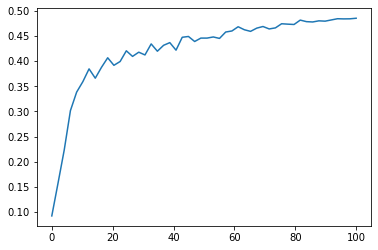

In [41]:
plt.plot(brightness,voltage22k)

In [45]:
trinket.ledOn()
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    voltage10k[i] = averageVoltage(5)
trinket.ledOff()

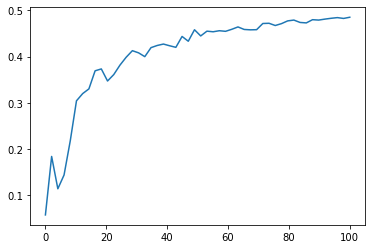

In [46]:
plt.plot(brightness,voltage10k)

In [47]:
trinket.ledOn()
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    voltage2200[i] = averageVoltage(5)
trinket.ledOff()

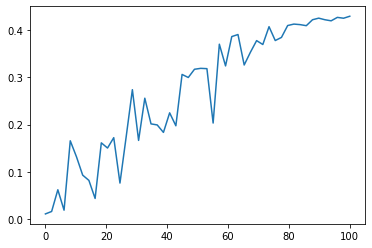

In [48]:
plt.plot(brightness,voltage2200)

In [50]:
trinket.ledOn()
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    voltage220[i] = averageVoltage(5)
trinket.ledOff()

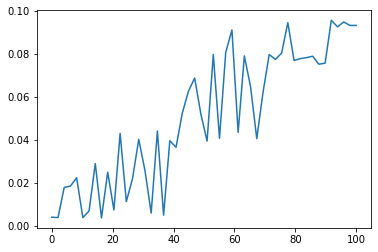

In [52]:
plt.plot(brightness,voltage220)

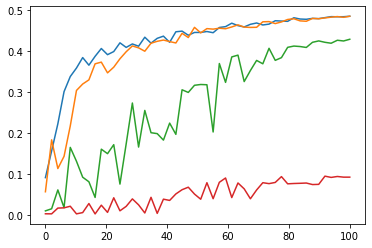

In [61]:
plt.plot(brightness,voltage22k)
plt.plot(brightness,voltage10k)
plt.plot(brightness,voltage2200)
plt.plot(brightness,voltage220)

# Task3: Reverse bias

We will now look at the effect of reverse biasing your diode. Choose a 10k$\Omega$ load resistor, this time however, place it in series with the photodiode. Connect the resistor between the __anode__ of the photodiode and the ground connect. Connect the __cathode__ of the photodiode to the 3.3V output from the trinket.
Perform a brightness run again, this time storing the voltages in an array `voltageReverseBias`. Plot the result on the same graph as the unbiased `voltageRL10k` you obtained in the previous task.
You will probably find the output to be rather noisy. This noise comes from a number of sources in both the resistor and photodiode, you can reduce it a little by put a capacitor in parallel with the load resistor. This has the effect of lowering the effective resistance for higher frequency signals like the noise. Make another run with the capacitor in place and plot with the pervious signal for comparison. The downside to this is the capacitor lowers bandwidth making it harder to detect short light pulses.

![Reverse bias](photodiode-reverse-bias.png "Reverse biased photodiode")

In [82]:
trinket.ledOn()
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    voltageReverseBias[i] = averageVoltage(5)
trinket.ledOff()

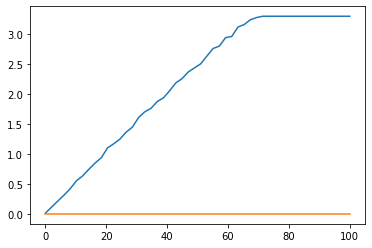

In [83]:
plt.plot(brightness,voltageReverseBias)
plt.plot(brightness,voltage10k)

# Task 4: Transimpedence amplifier

The final task we will build a so called _transimpedence amplifier_ (TIA) to detect our signal . This is perhaps one of the most common circuits in optoelectronic detectors. Their construction is an art in itself (there are 3 books just on this circuit on my bookshelf!). We will build the most basic form.
The basic TIA circuit is as shown below. The photodiode is connected to the inverting input of an op-amp and feedback is provided by a resistor $R_f$. The non-inverting input of the op-amp is connected to ground. As photocurrent $I_p$ flows the op-amp attempts keep the two inputs at the same voltage, since one is tied to ground that voltage is zero and the inverting input becomes a _virtual ground_. In order to acheive this op-amp must cancel out the current at the inverting input. By Kirchoff's junction rule this must happen when the feedback current $I_f$ equals the photocurrent. The end result is that the op-amp output voltage will be given by: $V_o = I_p R_f$    This votlage can be measured without loading the photodiode and the virtual ground means the voltage over the diode is zero. In this way we can measure the linear photodiode output current.

![TIA](tia-schematic.png "Transimpedence amplifier")

Set up the circuit as shown. Using MCP6   op-amp. Note the use of the capacitors on the supply line, this removes noise from the op-amp power supply and is good practice whenever using op-amps. __Important:__ The 10$\mu$F capacitor has a white band on it to indicate the negative leg. This must go to ground. _When incorrectly connected electrolytic capacitors can explode!_ Because we are using a single-supply op-amp there is only one way round the op-amp can go, with the annode connected to ground, this way current flows out of the inverting input and the output voltage goes positive to produce the feedback current. 
Make a brightness run measurement for the TIA as you did for the previous tasks. If you e get a completely flat-line response the most likely cause is placing the photodiode the wrong way around. Try using the same range of resistors for the feedback as you did for the load resistors in task 2. Again a 0.1$\mu$F capacitor in parallel with the resistor will reduce noise.
Plot your results.

In [ ]:
trinket.ledOn()
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    voltageOpAmp[i] = averageVoltage(5)
trinket.ledOff()

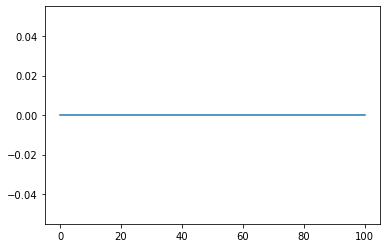

In [88]:
plt.plot(brightness,voltageOpAmp)

## Conclusion

The TIA is the most common circuit used for working with photodiodes. Although the simple reverse bias in Task 3 also produces a linear response, the amplifier circuit when properly tuned can be far faster, allowing even nanosecond light pulses to be measured. Unfortuntely that is difficult to demonstrate without an oscilloscope. You will need to build a TIA again for later experiment.

In [24]:
trinket.ledOff()
ser.close()